### STEP 1 – Load MovieLens data and reindex IDs

In this step, I load the MovieLens *ml-latest-small* dataset, and map the
original `userId` and `movieId` to contiguous integer indices
`user_idx ∈ {0,…,U−1}` and `movie_idx ∈ {0,…,M−1}`.
These reindexed IDs are the ones I will use consistently for all models
(PCA, HPF, and Poisson embeddings).


In [1]:
import numpy as np
import pandas as pd

# Paths relative to this notebook
ratings_path = "ml-latest-small/ratings.csv"
movies_path  = "ml-latest-small/movies.csv"

# Load data
ratings = pd.read_csv(ratings_path)
movies  = pd.read_csv(movies_path)

print("Ratings head:")
display(ratings.head())

print("Movies head:")
display(movies.head())

# Reindex userId and movieId to 0...(U-1), 0...(M-1)
unique_users  = ratings['userId'].unique()
unique_movies = ratings['movieId'].unique()

user_id_to_idx  = {uid: i for i, uid in enumerate(sorted(unique_users))}
movie_id_to_idx = {mid: i for i, mid in enumerate(sorted(unique_movies))}

ratings['user_idx']  = ratings['userId'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_to_idx)

U = ratings['user_idx'].max() + 1
M = ratings['movie_idx'].max() + 1

print(f"Users (U): {U}, Movies (M): {M}")


Ratings head:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Movies head:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Users (U): 610, Movies (M): 9724


### STEP 2 – Build per-user train/test splits and event lists

Here I create an 80/20 split of interactions *per user*, using timestamp
ordering. For each user, I keep (user, movie) pairs in:

- `train_ratings` for training,
- `test_ratings` for evaluation.

From these dataframes I construct:

- `user_train_items[u]`: array of movie indices rated by user *u* in train,
- `user_train_sets[u]`: same as a Python set (for fast “is this in train?” checks),
- `train_events`: list of `(u, i)` pairs for all train interactions,
- `test_events`: list of `(u, i)` pairs for all test interactions.

These event lists are what the Poisson embedding model will train and
evaluate on.

In [2]:
from collections import defaultdict

def train_test_split_per_user(ratings_df, test_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    train_rows = []
    test_rows  = []

    for u, grp in ratings_df.groupby('user_idx'):
        grp_sorted = grp.sort_values('timestamp')
        n = len(grp_sorted)
        if n <= 1:
            train_rows.append(grp_sorted)
            continue

        n_test = max(1, int(round(test_ratio * n)))
        test_idx = rng.choice(n, size=n_test, replace=False)
        mask = np.zeros(n, dtype=bool)
        mask[test_idx] = True

        test_rows.append(grp_sorted.iloc[mask])
        train_rows.append(grp_sorted.iloc[~mask])

    train_df = pd.concat(train_rows, ignore_index=True)
    test_df  = pd.concat(test_rows,  ignore_index=True)
    return train_df, test_df

# 80/20 per-user split
train_ratings, test_ratings = train_test_split_per_user(ratings, test_ratio=0.2, seed=42)
print("Train interactions:", len(train_ratings))
print("Test interactions :", len(test_ratings))

# Build user -> train movie arrays
user_train_items = [[] for _ in range(U)]
for row in train_ratings.itertuples(index=False):
    u = row.user_idx
    m = row.movie_idx
    user_train_items[u].append(m)

user_train_items = [np.array(items, dtype=np.int32) for items in user_train_items]
user_train_sets  = [set(items.tolist()) for items in user_train_items]

print("Total train interactions recovered from user_train_items:",
      sum(len(x) for x in user_train_items))

# Build event lists (u, i) for train and test
train_events = np.vstack([
    train_ratings['user_idx'].values,
    train_ratings['movie_idx'].values
]).T.astype(np.int32)

test_events = np.vstack([
    test_ratings['user_idx'].values,
    test_ratings['movie_idx'].values
]).T.astype(np.int32)

print("Number of train events:", train_events.shape[0])
print("Number of test events :", test_events.shape[0])
print("First 5 train events (u, i):")
print(train_events[:5])


Train interactions: 80672
Test interactions : 20164
Total train interactions recovered from user_train_items: 80672
Number of train events: 80672
Number of test events : 20164
First 5 train events (u, i):
[[   0  632]
 [   0  910]
 [   0 1492]
 [   0 2125]
 [   0 1978]]


### STEP 3 – Additive Poisson Embeddings (Additive P-EMB)

In the standard P-EMB model, the Poisson rate is parameterized in a
**log-linear** way:

\[
\lambda_{ui} = \exp(\rho_i^\top c_u)
\]

where \( \rho_i \) are target embeddings and \( c_u \) is a
context vector for user \(u\).

For **additive P-EMB**, we instead model the Poisson rate with a
**linear embedding function passed through a softplus**:

\[
s_{ui} = \rho_i^\top c_u,\quad
\lambda_{ui} = \text{softplus}(s_{ui}) = \log(1 + e^{s_{ui}}).
\]

This is an *additive* parameterization of the rate (not of the log-rate)
and provides a different inductive bias: deviations in \(s_{ui}\) have a
more moderate effect on \(\lambda_{ui}\) than in the pure exponential
model.

We keep the same event-based Poisson objective with negative sampling:

- Positive event \((u, i)\), \(x_{ui}=1\):
  \[
  \ell^+_{ui} = \log \lambda_{ui} - \lambda_{ui}.
  \]

- Negative events \((u, j)\) sampled where the user has no interaction:
  \[
  \ell^0_{uj} = - w_0 \lambda_{uj},
  \]
  with \(w_0 = 1\) for the additive model.

Training is done with SGD + AdaGrad exactly as in the standard P-EMB
notebook, but the gradients now go through the softplus function instead
of the exponential.


In [3]:
import numpy as np
import math

def softplus(x):
    # Stable softplus
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)


def train_pemb_additive(
    train_events,
    user_train_items,
    user_train_sets,
    U,
    M,
    K=40,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,       # weight for negatives (standard additive P-EMB uses 1.0)
    seed=0,
    verbose=True,
):
    """
    Additive Poisson embeddings with softplus rate:
        s_ui = rho_i^T c_u
        lambda_ui = softplus(s_ui)

    Event-based Poisson objective with negative sampling:
        For positive x=1: log lambda - lambda
        For negatives x=0: -w0 * lambda

    Uses SGD + AdaGrad on rho (target) and alpha (context).
    """
    rng = np.random.default_rng(seed)

    rho   = 0.01 * rng.standard_normal((M, K)).astype(np.float32)  # target
    alpha = 0.01 * rng.standard_normal((M, K)).astype(np.float32)  # context

    G_rho   = np.zeros_like(rho)
    G_alpha = np.zeros_like(alpha)
    eps = 1e-8

    train_events = np.array(train_events, dtype=np.int32)

    for epoch in range(1, n_epochs + 1):
        rng.shuffle(train_events)
        total_obj = 0.0
        count = 0

        for u, i in train_events:
            ctx_idx = user_train_items[u]
            if ctx_idx.size == 0:
                continue

            ctx_vec = alpha[ctx_idx].mean(axis=0)

            # ----- positive (x = 1) -----
            s_pos   = float(np.dot(rho[i], ctx_vec))
            lam_pos = float(softplus(s_pos))

            # Poisson log-likelihood: log lambda - lambda
            loss_pos = math.log(lam_pos + 1e-10) - lam_pos

            # Gradients:
            # d(lambda)/ds = sigmoid(s)
            sig_pos = 1.0 / (1.0 + math.exp(-s_pos))
            # dℓ/dλ = 1/λ - 1
            dL_dlam_pos = 1.0 / lam_pos - 1.0
            # dℓ/ds = dℓ/dλ * dλ/ds
            dL_ds_pos = dL_dlam_pos * sig_pos

            grad_rho_i = dL_ds_pos * ctx_vec - reg * rho[i]
            grad_ctx   = dL_ds_pos * rho[i]

            # ----- negatives (x = 0), sampled -----
            loss_neg = 0.0
            for _ in range(neg_per_pos):
                while True:
                    j = int(rng.integers(0, M))
                    if j not in user_train_sets[u]:
                        break

                s_neg   = float(np.dot(rho[j], ctx_vec))
                lam_neg = float(softplus(s_neg))
                loss_neg += -w0 * lam_neg

                sig_neg = 1.0 / (1.0 + math.exp(-s_neg))
                dL_ds_neg = -w0 * sig_neg

                grad_rho_j = dL_ds_neg * ctx_vec - reg * rho[j]

                G_rho[j] += grad_rho_j ** 2
                rho[j]   += lr * grad_rho_j / np.sqrt(G_rho[j] + eps)

                grad_ctx += dL_ds_neg * rho[j]

            # update rho[i] for positive
            G_rho[i] += grad_rho_i ** 2
            rho[i]   += lr * grad_rho_i / np.sqrt(G_rho[i] + eps)

            # update alpha for context items
            grad_ctx_per_item = grad_ctx / len(ctx_idx)
            for c in ctx_idx:
                grad_alpha_c = grad_ctx_per_item - reg * alpha[c]
                G_alpha[c]  += grad_alpha_c ** 2
                alpha[c]    += lr * grad_alpha_c / np.sqrt(G_alpha[c] + eps)

            total_obj += loss_pos + loss_neg
            count += 1

        if verbose:
            avg_obj = total_obj / max(count, 1)
            print(f"[Add. P-EMB] Epoch {epoch}/{n_epochs} approx objective per pos = {avg_obj:.6f}")

    return rho, alpha


def eval_pemb_additive_event_loglik(
    rho,
    alpha,
    test_events,
    user_train_items,
    user_train_sets,
    U,
    M,
    neg_per_pos=5,
    w0=1.0,
    seed=123,
):
    """
    Approximate normalized event-based Poisson log-likelihood for additive P-EMB
    with softplus rate and negative sampling.
    """
    rng = np.random.default_rng(seed)
    test_events = np.array(test_events, dtype=np.int32)

    ll_values = []

    for u, i in test_events:
        ctx_idx = user_train_items[u]
        if ctx_idx.size == 0:
            continue

        ctx_vec = alpha[ctx_idx].mean(axis=0)

        # positive
        s_pos   = float(np.dot(rho[i], ctx_vec))
        lam_pos = float(softplus(s_pos))
        ll_pos  = math.log(lam_pos + 1e-10) - lam_pos

        # negatives
        ll_neg = 0.0
        for _ in range(neg_per_pos):
            while True:
                j = int(rng.integers(0, M))
                if j not in user_train_sets[u]:
                    break
            s_neg   = float(np.dot(rho[j], ctx_vec))
            lam_neg = float(softplus(s_neg))
            ll_neg += -w0 * lam_neg

        ll_values.append(ll_pos + ll_neg)

    ll_values = np.array(ll_values)
    mean_ll = ll_values.mean()
    se_ll   = ll_values.std(ddof=1) / np.sqrt(len(ll_values))
    return mean_ll, se_ll


### STEP 5 – Baseline Ks for Additive P-EMB (K = 10, 20, 50)

Here I train additive P-EMB at the same baseline embedding dimensions
used for the matrix factorization and standard P-EMB models:

\[
K \in \{10, 20, 50\}.
\]

For each K, I report the **event-based Poisson log-likelihood per test
event ± SE**, using the same evaluation pipeline as before so that
results are directly comparable across models.


In [ ]:
import pandas as pd

K_list = [10, 20, 50]
results_add_baseline = []

for K in K_list:
    print(f"\n=== Additive P-EMB with K = {K} ===")
    rho_K, alpha_K = train_pemb_additive(
        train_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        K=K,
        n_epochs=5,
        neg_per_pos=5,
        lr=0.05,
        reg=1e-4,
        w0=1.0,
        seed=42,
        verbose=True,
    )

    train_ll, train_se = eval_pemb_additive_event_loglik(
        rho_K, alpha_K,
        test_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=1.0,
        seed=123,
    )

    test_ll, test_se = eval_pemb_additive_event_loglik(
        rho_K, alpha_K,
        test_events=test_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=1.0,
        seed=456,
    )

    results_add_baseline.append({
        "Model": "Add. P-EMB (event)",
        "K": K,
        "Train event ll": train_ll,
        "Train SE": train_se,
        "Test event ll": test_ll,
        "Test SE": test_se,
    })

results_add_baseline_df = pd.DataFrame(results_add_baseline)
results_add_baseline_df["Test event ll ± SE"] = (
    results_add_baseline_df["Test event ll"].round(6).astype(str)
    + " ± "
    + results_add_baseline_df["Test SE"].round(6).astype(str)
)

display(results_add_baseline_df[["Model", "K", "Test event ll", "Test SE"]])



=== Additive P-EMB with K = 10 ===
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.367096
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.141354
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.118317
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.101792
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2.095628

=== Additive P-EMB with K = 20 ===
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.326147
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.130249
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.105869
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.097796
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2.090039

=== Additive P-EMB with K = 50 ===
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.307383
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.124519
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.104093
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.092587
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2

,Model,K,Test event ll,Test SE
0,Add. P-EMB (event),10,-2.153776,0.005548
1,Add. P-EMB (event),20,-2.151448,0.005729
2,Add. P-EMB (event),50,-2.149812,0.005966


### STEP 6 – High-capacity Additive P-EMB (K = 40, 60, 80, 100)

Next, I increase the embedding dimension for additive P-EMB to

\[
K \in \{40, 60, 80, 100\}
\]

to study how additional capacity affects the **event-based Poisson
log-likelihood** under the additive parameterization of the Poisson
rate.

In [5]:
K_high_list = [40, 60, 80, 100]
results_add_highK = []

for K in K_high_list:
    print(f"\n=== Additive P-EMB with K = {K} ===")
    rho_K, alpha_K = train_pemb_additive(
        train_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        K=K,
        n_epochs=5,
        neg_per_pos=5,
        lr=0.05,
        reg=1e-4,
        w0=1.0,
        seed=42,
        verbose=True,
    )

    train_ll, train_se = eval_pemb_additive_event_loglik(
        rho_K, alpha_K,
        test_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=1.0,
        seed=123,
    )

    test_ll, test_se = eval_pemb_additive_event_loglik(
        rho_K, alpha_K,
        test_events=test_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=1.0,
        seed=456,
    )

    results_add_highK.append({
        "Model": "Add. P-EMB (event)",
        "K": K,
        "Train event ll": train_ll,
        "Train SE": train_se,
        "Test event ll": test_ll,
        "Test SE": test_se,
    })

results_add_highK_df = pd.DataFrame(results_add_highK)
results_add_highK_df["Test event ll ± SE"] = (
    results_add_highK_df["Test event ll"].round(6).astype(str)
    + " ± "
    + results_add_highK_df["Test SE"].round(6).astype(str)
)

display(results_add_highK_df[["Model", "K", "Test event ll", "Test SE"]])



=== Additive P-EMB with K = 40 ===
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.309965
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.123629
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.103695
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.094058
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2.085486

=== Additive P-EMB with K = 60 ===
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.311799
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.123719
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.102882
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.092488
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2.087151

=== Additive P-EMB with K = 80 ===
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.318648
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.125125
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.105098
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.093975
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2

,Model,K,Test event ll,Test SE
0,Add. P-EMB (event),40,-2.149050,0.005934
1,Add. P-EMB (event),60,-2.147761,0.006023
2,Add. P-EMB (event),80,-2.146337,0.006025
3,Add. P-EMB (event),100,-2.140174,0.006049


### STEP 7 – t-SNE visualizations for Additive P-EMB (K = 20 vs 100)

Finally, I visualize the movie embeddings learned by additive P-EMB at
two representative capacities:

- **K = 20** – comparable to the baseline latent dimension,
- **K = 100** – high-capacity additive P-EMB.

For each K, I:
1. Train additive P-EMB with the same hyperparameters as in the
   previous steps,
2. Take the target embeddings ρᵢ for movies with at least 20 ratings,
3. Project them to 2D with t-SNE,
4. Color points by primary genre.

This allows a direct visual comparison of the latent geometry learned by
the additive model versus the standard and downweighted P-EMB variants.


movies_meta not found – rebuilding from movies.csv and ratings.
movies_meta is available. Example rows:


,movieId,title,genres,movie_idx,primary_genre,num_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Adventure,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Adventure,110
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Comedy,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Comedy,7
4,5,Father of the Bride Part II (1995),Comedy,4,Comedy,49


Number of movies used in t-SNE: 1297

Training ADDITIVE P-EMB for K = 20
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.326147
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.130249
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.105869
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.097796
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2.090039

Training ADDITIVE P-EMB for K = 100
[Add. P-EMB] Epoch 1/5 approx objective per pos = -2.323742
[Add. P-EMB] Epoch 2/5 approx objective per pos = -2.126391
[Add. P-EMB] Epoch 3/5 approx objective per pos = -2.104713
[Add. P-EMB] Epoch 4/5 approx objective per pos = -2.092302
[Add. P-EMB] Epoch 5/5 approx objective per pos = -2.086782


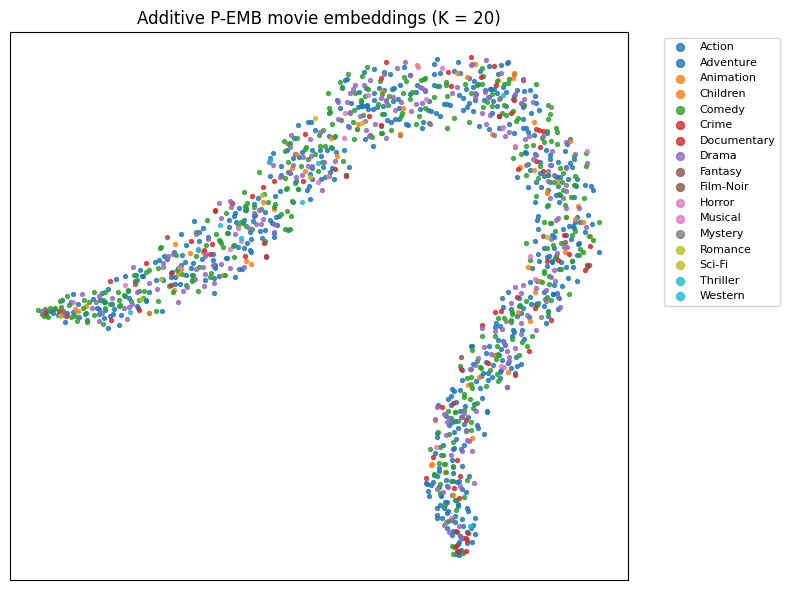

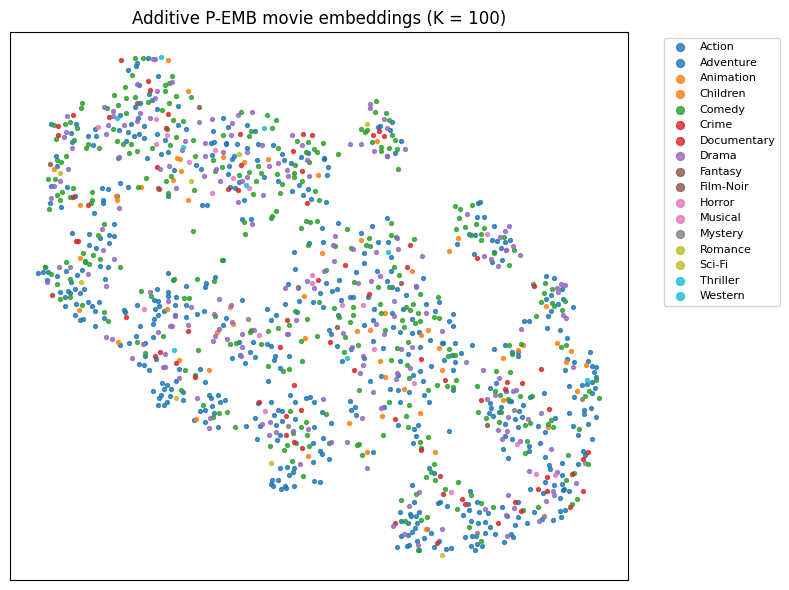

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

# ------------ 0) Ensure movies_meta exists ------------

if "movies_meta" not in globals():
    print("movies_meta not found – rebuilding from movies.csv and ratings.")

    if "ratings" not in globals():
        ratings_path = "ml-latest-small/ratings.csv"
        ratings = pd.read_csv(ratings_path)

    if "movie_id_to_idx" not in globals():
        unique_movies = ratings["movieId"].unique()
        movie_id_to_idx = {mid: i for i, mid in enumerate(sorted(unique_movies))}
        ratings["movie_idx"] = ratings["movieId"].map(movie_id_to_idx)

    movies_path = "ml-latest-small/movies.csv"
    movies = pd.read_csv(movies_path)

    movies["movie_idx"] = movies["movieId"].map(movie_id_to_idx)
    movies_meta = movies.dropna(subset=["movie_idx"]).copy()
    movies_meta["movie_idx"] = movies_meta["movie_idx"].astype(int)

    def get_primary_genre(genres):
        if not isinstance(genres, str):
            return "Unknown"
        if genres == "(no genres listed)":
            return "Unknown"
        return genres.split("|")[0]

    movies_meta["primary_genre"] = movies_meta["genres"].apply(get_primary_genre)

    movie_counts = ratings.groupby("movie_idx").size()
    movies_meta["num_ratings"] = movies_meta["movie_idx"].map(movie_counts).fillna(0).astype(int)

print("movies_meta is available. Example rows:")
display(movies_meta.head())

# ------------ 1) Movie subset and colors ------------

min_ratings = 20
movies_for_tsne = movies_meta[movies_meta["num_ratings"] >= min_ratings].copy()

movie_idx_arr = movies_for_tsne["movie_idx"].values
genres_arr    = movies_for_tsne["primary_genre"].values

print("Number of movies used in t-SNE:", len(movie_idx_arr))

unique_genres = sorted(movies_for_tsne["primary_genre"].unique())
cmap = matplotlib.colormaps.get_cmap("tab10")
genre_to_color = {g: cmap(i / max(1, len(unique_genres) - 1)) for i, g in enumerate(unique_genres)}

# ------------ 2) Train additive P-EMB for K = 20 and K = 100 ------------

K_low  = 20
K_high = 100

print(f"\nTraining ADDITIVE P-EMB for K = {K_low}")
rho_add_low, alpha_add_low = train_pemb_additive(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K_low,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,
    seed=42,
    verbose=True,
)

print(f"\nTraining ADDITIVE P-EMB for K = {K_high}")
rho_add_high, alpha_add_high = train_pemb_additive(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K_high,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,
    seed=42,
    verbose=True,
)

# ------------ 3) Helper to run t-SNE and plot ------------

def plot_tsne_for_rho_add(rho, K):
    emb = rho[movie_idx_arr]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        init="random",
    )
    coords = tsne.fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for g in unique_genres:
        mask = (genres_arr == g)
        if mask.sum() == 0:
            continue
        plt.scatter(
            coords[mask, 0],
            coords[mask, 1],
            s=8,
            color=genre_to_color[g],
            label=g,
            alpha=0.8,
        )

    plt.title(f"Additive P-EMB movie embeddings (K = {K})")
    plt.xticks([])
    plt.yticks([])
    plt.legend(
        markerscale=2,
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

# ------------ 4) Generate the two t-SNE plots ------------

plot_tsne_for_rho_add(rho_add_low,  K_low)
plot_tsne_for_rho_add(rho_add_high, K_high)
